# EveryBeam LOFAR integration tests

These tests are all setup and explained in `test_OSKAR-MWA.ipynb`, so check that out first if you haven't already.

Goes without saying, but these tests rely on `everybeam` being installed.

In [2]:
from subprocess import call
from astropy.io import fits
import numpy as np
from astropy.table import Column, Table
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy import units as u
import matplotlib.pyplot as plt
import numpy.testing as npt
from astropy.constants import c
from astropy.wcs import WCS
import everybeam as eb
from wodenpy.primary_beam.everybeam import load_OSKAR_telescope, load_LOFAR_telescope, get_everybeam_norm, run_everybeam, radec_to_xyz
import erfa
import mwa_hyperbeam

##A bunch of test and plotting code lives here so we can use it in multile notebooks
from eb_testing_code import create_WCS, plot_jones_on_sky, plot_everybeam_on_sky, make_sky_models, read_uvfits, convert_inst_to_stokes, test_stokes_recovery, getFDF, findpeaks, test_RM_recovery, make_RM_skymodel

C = c.to('m/s').value

### Image the beam on the sky

First up, let's see if we can just plot a LOFAR station beam to check it looks sensible.

In [9]:
ra0 = 0
dec0 = 53


lofar_lat = 52.905329712
lofar_long = 6.867996528

##pick a time/date that sticks our phase centre overhead
date = "2024-07-21T03:35:00"
##Assume that the OSKAR telescope is near the MWA??
lofar_location = EarthLocation(lat=lofar_lat*u.deg, 
                               lon=lofar_long*u.deg)

observing_time = Time(date, scale='utc', location=lofar_location)

##Grab the LST
LST = observing_time.sidereal_time('mean')
LST_deg = LST.value*15
print(f"LST: {LST_deg} deg, RA: {ra0}")



LST: 0.018621824847493876 deg, RA: 0


Creating LOBESElementResponse for station CS001LBA failed because: 
Coefficients file /home/jack-line/software/anaconda3/envs/everybeam/share/everybeam/lobes/LOBES_CS001LBA.h5 does not exist.
Switching to HamakerElementResponse instead. Further warnings of this type will be suppressed.


2024-08-26 05:48:20	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:48:20	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:48:20	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:48:20	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:48:20	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:48:20	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:48:20	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

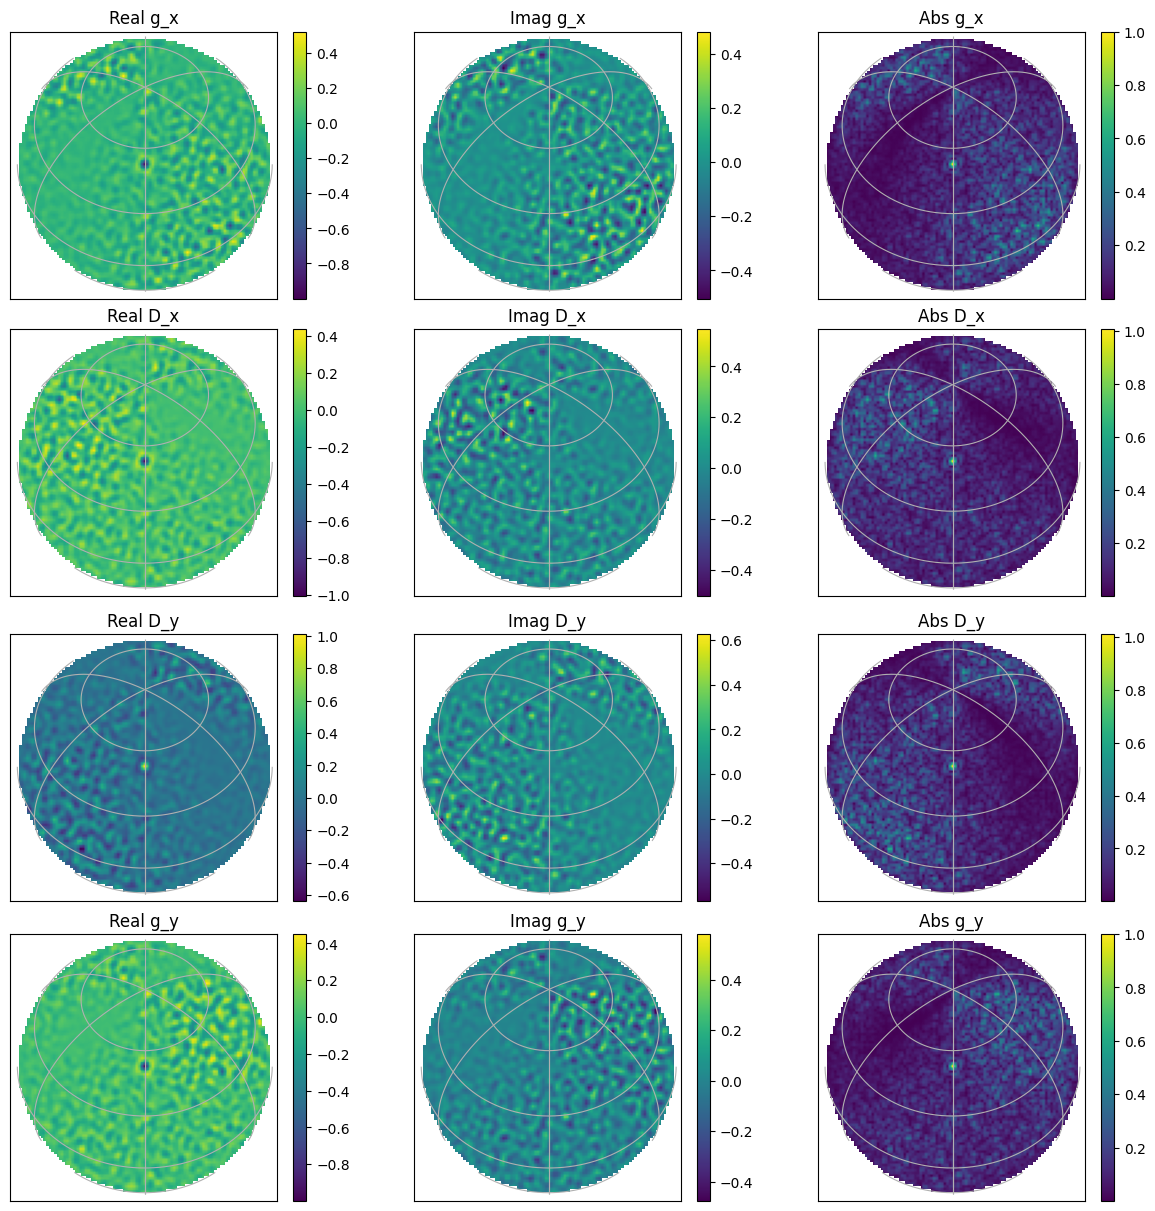

In [4]:
ms_path="lba.MS"

# Load the telescope
telescope = load_LOFAR_telescope(ms_path)

freq = 100e+6
station_id = 0

plot_everybeam_on_sky(ra0, dec0, observing_time, freq, station_id, telescope)

This is confusing to me, as the leakages seem to be the same strength as the gains. Is this actually returning a jones matrix, or is it something different?

## Stokes recovery
Now try to recover single point source of either Stokes I, Q, U or V.

In [5]:
make_sky_models(ra0, dec0)

freq_reso = 1e+6
# low_freq = 180e+6
# high_freq = 210e+6
low_freq = 100e+6
high_freq = 150e+6


num_freq_chans = int((high_freq - low_freq) / freq_reso)

primary_beam = "everybeam_LOFAR"

for pol in ['I', 'Q', 'U', 'V']:
# for pol in ['I']:

    uvfits_name = f"stokes{pol}_{primary_beam}"
    cat_name = f'{pol}_source.fits'
    
    ##The command to run WODEN
    command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
    command += f'--latitude={lofar_lat} --longitude={lofar_long} '
    command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
    command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
    command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
    command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
    command += f'--time_res=2 --num_time_steps=1 --IAU_order '
    command += f'--beam_ms_path=lba.MS'
    
    call(command, shell=True)

Successful readonly open of default-locked table lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 53.00000deg
Obs epoch initial LST was 0.0227999082 deg
Setting initial J2000 LST to 359.7122367548 deg
Setting initial mjd to 60512.1493171296
After precession initial latitude of the array is 52.7688502802 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
HERE 7
Creating LOBESElementResponse for station CS001LBA failed because: 
Coefficients file /home/jack-line/software/anaconda3/envs/everybeam/share/everybeam/lob

2024-08-26 05:48:27	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:48:27	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:48:27	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:48:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:48:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:48:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:48:27	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 7
YO YO YO woden_settings->beamtype: 7
Simulating band 01 with bottom freq 1.00000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished
Successful readonly open of default-locked table lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 53.00000deg
Obs epoch initial LST was 0.0227999082 deg
Setting initial J2000 LST to 359.7122367548 deg
Setting initial mjd to 60512.1493171296
After precession initial latitude of the array is 52.7688502802 deg
We ar

2024-08-26 05:48:29	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:48:29	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:48:29	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:48:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:48:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:48:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:48:29	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 7
YO YO YO woden_settings->beamtype: 7
Simulating band 01 with bottom freq 1.00000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished
Successful readonly open of default-locked table lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 53.00000deg
Obs epoch initial LST was 0.0227999082 deg
Setting initial J2000 LST to 359.7122367548 deg
Setting initial mjd to 60512.1493171296
After precession initial latitude of the array is 52.7688502802 deg
We ar

2024-08-26 05:48:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:48:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:48:31	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:48:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:48:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:48:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:48:31	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 7
YO YO YO woden_settings->beamtype: 7
Simulating band 01 with bottom freq 1.00000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished
Successful readonly open of default-locked table lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 53.00000deg
Obs epoch initial LST was 0.0227999082 deg
Setting initial J2000 LST to 359.7122367548 deg
Setting initial mjd to 60512.1493171296
After precession initial latitude of the array is 52.7688502802 deg
We ar

2024-08-26 05:48:33	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:48:33	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:48:33	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:48:33	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:48:33	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:48:33	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:48:33	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 7
YO YO YO woden_settings->beamtype: 7
Simulating band 01 with bottom freq 1.00000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished


In [6]:
for pol in ['I', 'Q', 'U', 'V']:
    uvfits_name = f"stokes{pol}_everybeam_LOFAR"
    XX, XY, YX, YY = read_uvfits(f'{uvfits_name}_band01.uvfits')
    ##pick a random baseline to plot, they should all be the sam
    baseline = 0

    recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])
    
    print(pol, recover_I[0].real, recover_Q[0].real, recover_U[0].real, recover_V[0].real)
    print(pol, recover_I[-1].real, recover_Q[-1].real, recover_U[-1].real, recover_V[-1].real)
    
    test_stokes_recovery(pol, 'everybeam_LOFAR', atol=5e-2)

I 1.0 0.0 0.0 0.0
I 1.0 0.0 0.0 0.0
Testing Stokes I
Stokes I passed
Q 0.0 1.0 0.0 0.0
Q 0.0 1.0 0.0 0.0
Testing Stokes Q
Stokes Q passed
U 0.0 0.0 0.9999998 -0.00062536146
U 0.0 0.0 0.9997271 0.023361286
Testing Stokes U
Stokes U passed
V 0.0 0.0 0.00062536146 0.9999998
V 0.0 0.0 -0.023361286 0.9997271
Testing Stokes V
Stokes V passed


## RM recovery

In [11]:
phi_RM, pol_frac = make_RM_skymodel(ra0, dec0)

freq_reso = 0.1e+6
low_freq = 100e+6
high_freq = 130e+6
num_freq_chans = int((high_freq - low_freq) / freq_reso)


primary_beam = "everybeam_LOFAR"

uvfits_name = f"rm_source_{primary_beam}"
cat_name = 'RM_source.fits'

##The command to run WODEN
command = f'run_woden.py --ra0={ra0} --dec0={dec0} '
command += f'--date={date} --output_uvfits_prepend={uvfits_name} '
command += f'--latitude={lofar_lat} --longitude={lofar_long} '
command += f'--cat_filename={cat_name} --primary_beam={primary_beam} '
command += f'--lowest_channel_freq={low_freq} --freq_res={freq_reso} '
command += f'--num_freq_channels={num_freq_chans} --band_nums=1 '
command += f'--time_res=2 --num_time_steps=1 --IAU_order '
command += f'--beam_ms_path=lba.MS'

call(command, shell=True)

Successful readonly open of default-locked table lba.MS/ANTENNA: 10 columns, 37 rows
You are using WODEN commit: 2c8bbe6
LOADING IN /home/jack-line/software/anaconda3/envs/everybeam/lib/python3.12/site-packages/wodenpy/libwoden_double.so
Setting phase centre RA,DEC 0.00000deg 53.00000deg
Obs epoch initial LST was 0.0227999082 deg
Setting initial J2000 LST to 359.7122367548 deg
Setting initial mjd to 60512.1493171296
After precession initial latitude of the array is 52.7688502802 deg
We are precessing the array
Doing the initial reading/mapping of sky model into chunks
INFO: couldn't find second table containing shapelet information, so not attempting to load any shapelets.
Mapping took 0.0 mins
Have read in 1 components
After cropping there are 1 components
After chunking there are 1 chunks
Reading chunks skymodel chunks 0:50
HERE 7
Creating LOBESElementResponse for station CS001LBA failed because: 
Coefficients file /home/jack-line/software/anaconda3/envs/everybeam/share/everybeam/lob

2024-08-26 05:57:03	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)	Leap second table TAI_UTC seems out-of-date.
2024-08-26 05:57:03	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	Until the table is updated (see the CASA documentation or your system admin),
2024-08-26 05:57:03	SEVERE	MeasTable::dUTC(Double) (file ./measures/Measures/MeasTable.cc, line 4292)+	times and coordinates derived from UTC could be wrong by 1s or more.
2024-08-26 05:57:03	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)	Requested data table IERSeop97 cannot be found in the searched directories:
2024-08-26 05:57:03	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/ephemerides/
2024-08-26 05:57:03	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS.cc, line 389)+	/var/lib/casacore/data/geodetic/
2024-08-26 05:57:03	WARN	MeasIERS::findTab (file ./measures/Measures/MeasIERS

Reading chunks 0:50 took 0.0 mins
WODEN is using DOUBLE precision
woden_settings->beamtype: 7
YO YO YO woden_settings->beamtype: 7
Simulating band 01 with bottom freq 1.00000000e+08
About to copy the chunked source to the GPU
Have copied across the chunk to the GPU
Processing chunk 0
	Number of components in chunk are: P 1 G 0 S_coeffs 0
	Doing point components
	Extrapolating fluxes and beams...
	Extrapolating fluxes and beams done.
	Doing visi kernel...
	Visi kernel done
GPU calls for band 1 finished


0

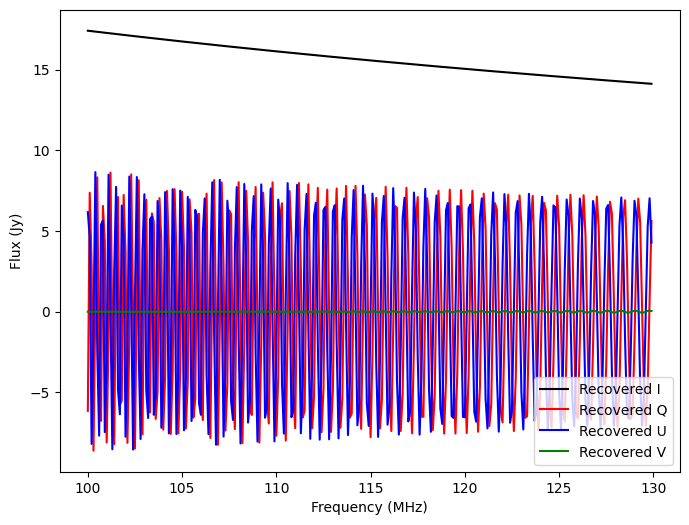

In [12]:
XX, XY, YX, YY = read_uvfits('rm_source_everybeam_LOFAR_band01.uvfits')
baseline = 0    
recover_I, recover_Q, recover_U, recover_V = convert_inst_to_stokes(XX[baseline], XY[baseline], YX[baseline], YY[baseline])

    
freqs = np.arange(low_freq, high_freq, freq_reso)

fig, axs = plt.subplots(1, 1, figsize=(8, 6))

axs.plot(freqs / 1e+6, recover_I.real, 'k-', label='Recovered I')
axs.plot(freqs / 1e+6, recover_Q.real, 'r', label='Recovered Q')
axs.plot(freqs / 1e+6, recover_U.real, 'b', label='Recovered U')
axs.plot(freqs / 1e+6, recover_V.real, 'g', label='Recovered V')

axs.legend()

axs.set_xlabel('Frequency (MHz)')
axs.set_ylabel('Flux (Jy)')

plt.show()

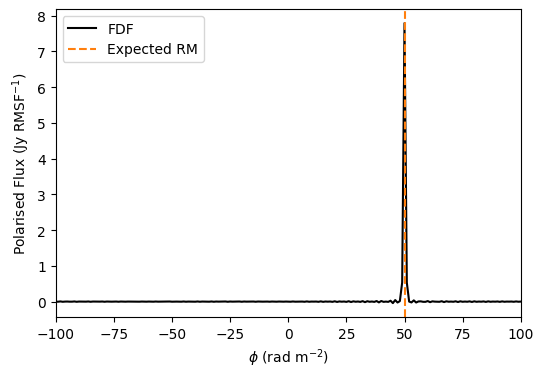

Recovered RM: 50.0 Expected RM: 50
Recovered Pol. Fraction: 0.49999756 Expected Pol Fraction 0.5


In [13]:
test_RM_recovery(uvfits_name, phi_RM, pol_frac, freqs)